# 3.5 에러 분석

## 3.5.0 이전 내용 중 필요한 로직

In [11]:
## 기본

import warnings
warnings.filterwarnings('ignore')

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# MNIST 데이터셋 불러오기
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print('load mnist done')

# 데이터셋 분리
X, y = mnist['data'], mnist['target']

# 샘플 데이터 (숫자 5)
some_digit = X[0]

# 레이블 데이터 타입 변환(문자열 -> 숫자)
y = y.astype(np.uint8)

# 테스트 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 특성 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

load mnist done


In [12]:
# SGD 분류기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
#sgd_clf.fit(X_train_scaled, y_train) # 저장한 모델(mnist_sgd_clf_ch03) 불러오는 것으로 대체
print('sgd clf fitting done')

sgd clf fitting done


In [13]:
# 모델 저장
import joblib

my_model = sgd_clf
joblib.dump(my_model, '../models/mnist_sgd_clf_ch03.pkl') # DIFF

['../models/mnist_sgd_clf_ch03.pkl']

In [14]:
# 모델 불러오기
sgd_clf = joblib.load('../models/mnist_sgd_clf_ch03.pkl')

In [25]:
## 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "../"
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 그림 저장 함수
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

<br>

## 3.5.1 모델 성능 향상 : 에러 분석

- 먼저 가능성이 높은 모델을 하나 찾았다고 가정
- 이 모델의 성능을 향상시킬 방법을 찾아보자
- 한 가지 방법은 **만들어진 에러의 종류를 분석**하는 것이다.

<br>

### 3.5.1.1 오차 행렬 확인

- `cross_val_predict()` 함수를 사용해 예측을 만든다.
- 이 예측을 사용하여 `confusion_matrix()` 함수를 호출한다.

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

<br>

### 3.5.1.2 오차 행렬 시각화

- 오차 행렬을 맷플롯립의 `matshow()` 함수를 사용해 이미지로 표현하면 보기에 편리하다.

그림 저장: confusion_matrix_plot


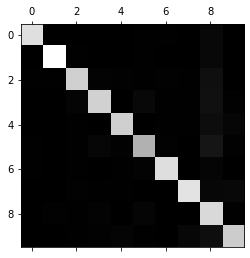

In [33]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

- 이 오차 행렬은 대부분의 이미지가 주대각선에 있으므로 올바르게 분류되었음을 나타낸다.
- 숫자 5는 다른 숫자 조금 더 어두워 보인다.
  - 배열에서 가장 큰 값은 흰색으로, 가장 작은 값은 검정색으로 정규화되어 그려진다.
  - 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다.

<br>

### 3.5.1.3 클래스별 에러 비율 비교

- 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다.
  - 에러의 절대 갯수를 나누는 것이 아니다.
  - 갯수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보인다.  
  (MNIST는 클래스별 이미지 개수가 동일하지 않음)

In [18]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums # 각 클래스별 이미지 갯수

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [19]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

<br>

- 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그린다.

In [20]:
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx

array([[0.        , 0.        , 0.00371433, 0.00084417, 0.00135067,
        0.00725983, 0.006078  , 0.001013  , 0.03798751, 0.00016883],
       [0.        , 0.        , 0.00548799, 0.00355977, 0.0005933 ,
        0.00652625, 0.0005933 , 0.00103827, 0.03144468, 0.00148324],
       [0.00453172, 0.00453172, 0.        , 0.01544142, 0.01225243,
        0.00453172, 0.01124538, 0.0060423 , 0.06344411, 0.00184626],
       [0.00358832, 0.00277279, 0.01908335, 0.        , 0.00032621,
        0.03311042, 0.00440385, 0.00652422, 0.06573153, 0.0119067 ],
       [0.00205409, 0.00239644, 0.00701814, 0.00154057, 0.        ,
        0.00205409, 0.00581992, 0.0046217 , 0.05939747, 0.02807258],
       [0.00498063, 0.00276702, 0.00553403, 0.03099059, 0.00977679,
        0.        , 0.01383509, 0.00258255, 0.09869028, 0.01106807],
       [0.00506928, 0.00253464, 0.00709699, 0.00050693, 0.00743494,
        0.01639067, 0.        , 0.00050693, 0.02213586, 0.00016898],
       [0.00335196, 0.00159617, 0.0081404

그림 저장: confusion_matrix_errors_plot


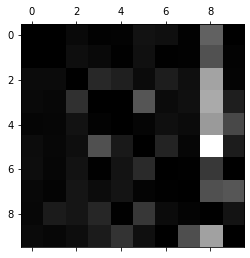

In [34]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

- 여기서 분류기가 만든 에러를 확실히 볼 수 있다.
  - 행 : 실제 클래스
  - 열 : 예측한 클래스  
  
  
- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다.
- 클래스 8의 행은 나쁘지 않다.
  - 이는 실제 8이 적절히 8로 분류되었다는 것을 말해준다.  
  
  
- 오차 행렬은 반드시 대칭인 것은 아니다.
  - 3과 5가 (서로) 많이 혼동되고 있는 것도 볼 수 있다.

<br>

### 3.5.1.4 오차 행렬 분석을 통한 분류기 성능 향상 방안에 대한 통찰

- 위 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다.
- 개선 방안
  - 8처럼 보이는(실제 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습
  - 분류기에 도움 될 만한 특성을 더 찾아본다.
    - ex) 동심원의 수를 세는 알고리즘 (8: 2개, 6: 1개, 5: 0개)
    - ex) 동심원 같은 어떤 패턴이 드러나도록 다음의 방법들을 활용하여 이미지 전처리
      - Scikit-Image
      - Pillow
      - OpenCV

<br>

### 3.5.1.5 3과 5 샘플 시각화

- `plot_digits()` 는 단순히 맷플롯립의 `imshow()` 함수를 사용하는 함수이다.

In [23]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: error_analysis_digits_plot


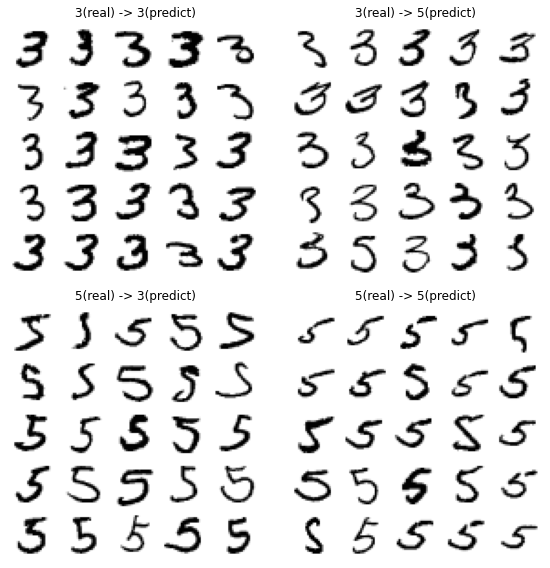

In [32]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3을 3으로 올바르게 예측한 샘플들
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3을 5으로 잘못 예측한 샘플들
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5을 3으로 잘못 예측한 샘플들
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5을 5으로 올바르게 예측한 샘플들

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5); plt.title('3(real) -> 3(predict)')
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5); plt.title('3(real) -> 5(predict)')
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5); plt.title('5(real) -> 3(predict)')
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5); plt.title('5(real) -> 5(predict)')

save_fig("error_analysis_digits_plot")

plt.show()

**분류기가 잘못 분류한 숫자들의 유형**

- 정말로 잘못 쓰여진 숫자들
- 사람도 분류하기 어려운 숫자들
- 대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하긴 어렵다.

**분류기가 잘못 분류한 원인 : 선형 모델(`SGDClassifier`) 사용**

- 선형 분류기는 클래스마다 픽셀에 가중치를 할당
- 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산
- 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 혼동하기 쉬움

**3과 5의 주요 차이**

- 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치
- 이를 통해 **분류기는 이미지의 위치나 회전 방향에 매우 민감**하다는 것을 알 수 있다.

**3과 5의 에러를 줄이는 방법**

- 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리를 한다.